In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import langid
import os
import sys
import warnings

from bokeh.plotting import figure, show, output_notebook

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
output_notebook()

Loading BokehJS ...

# Load Data

In [3]:
%%time
# ddf = dd.read_parquet("processed_data/joined.parquet.snappy", engine="pyarrow")
df = pd.read_parquet("processed_data/joined_data_lang_detected.parquet")
ddf = dd.from_pandas(df, npartitions=5)

CPU times: user 10.1 s, sys: 6.04 s, total: 16.1 s
Wall time: 27.5 s


In [4]:
ddf.head()
# df.head()

,r_id,b_id,u_id,r_stars,r_date,r_text,r_useful,r_funny,r_cool,b_stars,b_review_count,u_review_count,u_yelping_since,u_friends_count,is_english
0,4,6317,164431,5,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo...",1,0,1,4.0,181,9,2014-01-17 19:20:57,1,0
1,9,914,154297,3,2016-03-30 22:46:33,This easter instead of going to Lopez Lake we ...,1,1,0,4.5,13,24,2015-10-27 22:53:34,1,0
2,11,3877,35412,5,2015-06-21 14:48:06,My experience with Shalimar was nothing but wo...,2,0,0,2.5,8,39,2009-01-27 21:20:30,7,0
3,18,12041,21756,4,2014-08-10 19:41:43,The hubby and I have been here on multiple occ...,1,0,0,4.0,398,74,2009-07-24 14:30:28,112,0
4,19,295,80128,5,2016-03-07 00:02:18,I go to blow bar to get my brows done by natal...,2,0,1,4.0,55,27,2012-02-26 05:18:05,8,0


# Basic EDA

## Dataset Statisitics

In [5]:
ddf.describe().compute()
# df.describe()

,b_id,u_id,r_stars,r_useful,r_funny,r_cool,b_stars,b_review_count,u_review_count,u_friends_count,is_english
count,2.576655e+06,2.576655e+06,2.576655e+06,2.576655e+06,2.576655e+06,2.576655e+06,2.576655e+06,2.576655e+06,2.576655e+06,2.576655e+06,2.576655e+06
mean,7.479263e+04,4.266285e+05,3.607624e+00,2.651250e+00,6.412120e-01,1.038119e+00,3.742953e+00,3.369155e+02,1.913309e+02,1.890629e+02,3.182421e-04
std,4.357554e+04,4.963609e+05,1.538495e+00,4.625320e+00,2.446789e+00,3.283233e+00,7.945866e-01,6.658551e+02,4.975412e+02,5.674223e+02,1.783650e-02
min,2.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.678200e+04,6.111600e+04,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.500000e+00,4.100000e+01,1.100000e+01,2.000000e+00,0.000000e+00
50%,7.491900e+04,2.418490e+05,4.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.300000e+02,4.600000e+01,4.100000e+01,0.000000e+00
75%,1.127330e+05,8.525820e+05,5.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,4.500000e+00,3.740000e+02,1.820000e+02,1.710000e+02,0.000000e+00
max,1.503460e+05,1.987895e+06,5.000000e+00,1.182000e+03,7.920000e+02,4.040000e+02,5.000000e+00,7.568000e+03,1.747300e+04,1.499500e+04,1.000000e+00


In [6]:
ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 15 entries, r_id to is_english
dtypes: datetime64[ns](2), object(2), float64(1), int64(10)

## Missing Data Information

In [7]:
pd.DataFrame(ddf.isna().sum().compute() / ddf.isna().count().compute(), columns=["fraction_missing"])
# pd.DataFrame(df.isna().sum()/ df.isna().count(), columns=["fraction_missing"])

,fraction_missing
r_id,0.0
b_id,0.0
u_id,0.0
r_stars,0.0
r_date,0.0
r_text,0.0
r_useful,0.0
r_funny,0.0
r_cool,0.0
b_stars,0.0


## Histogram of review stars

In [8]:
def bokeh_hist(hist, edges, **kwargs):
    """ Function to plot the histogram in Bokeh """
    x = kwargs.get('x', None)
    pdf = kwargs.get('pdf', None)
    cdf = kwargs.get('cdf', None)
    title = kwargs.get('title', "Title")
    height = kwargs.get('height', 350)
    
    p = figure(height=height, title=title, x_axis_label=kwargs.get("x_label", "x"), y_axis_label=kwargs.get("y_label", "y"),
              y_axis_type=kwargs.get("y_axis_type", "linear"), y_range=kwargs.get("y_range", None))
    
    p.quad(bottom=0, top=hist, left=edges[:-1], right=edges[1:], fill_color=kwargs.get('fill_color', 'navy'), 
           line_color=kwargs.get('line_color', 'white'), 
           alpha=kwargs.get('alpha', 0.5))
    
    if pdf is not None and x is not None:
        p.line(x, pdf, line_color=kwargs.get('pdf_color', 'darkorange'), legend="PDF")
        
    if cdf is not None and x is not None:
        p.line(x, cdf, line_color=kwargs.get('cdf_color', 'forestgreen'), legend="CDF")
   
    p.legend.location = "center_right"
    show(p)
    
    
def bokeh_dist(x, pdf, **kwargs):
    """ Function to plot the distribution in Bokeh """
    
    title = kwargs.get('title', "Title")
    height = kwargs.get('height', 350)

    p = figure(height=height, title=title, x_axis_label=kwargs.get("x_label", "x"), y_axis_label=kwargs.get("y_label", "y"))

    p.line(x, pdf, line_color=kwargs.get('pdf_color', 'navy'), line_width=kwargs.get('line_width', 1.0))
    show(p)

In [9]:
r_star_hist, r_star_edge = np.histogram(ddf["r_stars"].compute().values, bins=4, range=(1, 5))
# r_star_hist, r_star_edge = np.histogram(df["r_stars"].values, bins=4, range=(1, 5))
bokeh_hist(r_star_hist, r_star_edge, title="Distribution of review stars", x_label="review stars", y_label="frequency", alpha=0.85)

As per the above histogram, the data consists of reviews mostly of ratings between $4$ and $5$. Second to that are the reviews with ratings between $1$ and $2$.

## Distribution of Useful ratings

In [10]:
def calc_pdf(data, attr, isdask=False):
    """ Function to calculate the Probability Density Function """
    if isdask:
        x = np.linspace(data[attr].min().compute(), data[attr].max().compute())
        mu, sigma = data[attr].mean().compute(), data[attr].std().compute()
        
    elif attr is None:
        x = np.linspace(np.min(data), np.max(data))
        mu, sigma = np.mean(x), np.std(x)
        
    else:
        x = np.linspace(data[attr].min(), data[attr].max())
        mu, sigma = data[attr].mean(), data[attr].std()
        
    pdf = 1/(sigma*np.sqrt(2 * np.pi)) * np.exp(-(x - mu) ** 2/(2 * sigma ** 2))
    
    return x, pdf

In [11]:
# x = np.linspace(0, ddf["r_useful"].max().compute())
# mu, sigma = ddf["r_useful"].mean().compute(), ddf["r_useful"].std().compute()

use_x, use_pdf = calc_pdf(ddf, "r_useful", isdask=True)

In [12]:
bokeh_dist(use_x, use_pdf, x_label="useful ratings", y_label="pdf", pdf_color="cornflowerblue", title="Distribution of Useful Ratings")

The `useful_ratings` is heavily *right-skewed*. Meaning most of instances has `r_useful` set to range between $1$ to $20$. There are only **few reviews** that are found to be *extremely* useful. So, the question is Does the **popularity** of the *reviewer* affects such behaviour? 

### Minimum Value of Useful Ratings

In [13]:
ddf["r_useful"].min().compute()
# df["r_useful"].min()

-1

In [14]:
# ddf[ddf["r_useful"] == ddf["r_useful"].min().compute()].compute().shape
print(f'Number of records with min value : {ddf[ddf["r_useful"] == ddf["r_useful"].min().compute()].compute().shape[0]}')

Number of records with min value : 4


It is weird that only $4$ instances of negative ratings are present in our data. Could this be a *data entry* problem? Or is there any downvoting functionality on *Yelp*?

### Maximum Value of Useful Ratings

In [15]:
ddf["r_useful"].max().compute()

1182

In [16]:
print(f'Number of records with max value: {ddf[ddf["r_useful"] == ddf["r_useful"].max().compute()].compute().shape[0]}')

Number of records with max value: 1


And there's only a single record with the maximum value. Is that review really helpful? Is it an old review?

## Distribution of Funny Ratings

In [17]:
fun_x, fun_pdf = calc_pdf(ddf, "r_funny", isdask=True)
bokeh_dist(fun_x, fun_pdf, x_label="funny ratings", y_label="pdf", pdf_color="tomato", title="Distribution of Useful Ratings")

The distribution of `r_funny` is similar to the distribution of `r_useful`. 

### Minimum Value of Funny Ratings

In [18]:
ddf["r_funny"].min().compute()

-1

In [19]:
print(f'Number of records with min value : {ddf[ddf["r_funny"] == ddf["r_funny"].min()].compute().shape[0]}')

Number of records with min value : 2


There are only $2$ instances where the minimum value of `r_funny` is $-1$. Is this some kind of a data entry?

### Maximum Value of Funny Ratings

In [20]:
ddf["r_funny"].max().compute()

792

In [21]:
print(f'Number of records with max value: {ddf[ddf["r_funny"] == ddf["r_funny"].max().compute()].compute().shape[0]}')

Number of records with max value: 1


Just like `r_useful`, the `r_funny` also has only a single record with the maximum value.

## Distribution of Cool Ratings

In [22]:
cool_x, cool_pdf = calc_pdf(ddf, "r_cool", isdask=True)
bokeh_dist(cool_x, cool_pdf, x_label="cool ratings", y_label="pdf", pdf_color="mediumseagreen", title="Distribution of Useful Ratings")

So, the ratings of `r_useful`, `r_cool`, `r_funny` almost have similar distributions.

### Minimum Value of Cool Ratings

In [23]:
ddf["r_cool"].min().compute()

-1

In [24]:
print(f'Number of records with min value : {ddf[ddf["r_cool"] == ddf["r_cool"].min()].compute().shape[0]}')

Number of records with min value : 1


There's only a single record with minimum value for `r_cool`

### Maximum Value of Cool Ratings

In [25]:
ddf["r_cool"].max().compute()

404

In [26]:
print(f'Number of records with min value : {ddf[ddf["r_cool"] == ddf["r_cool"].max()].compute().shape[0]}')

Number of records with min value : 1


The number of records with maximum value is also $1$ for `r_cool`

## Histogram of b_stars

In [27]:
b_stars_hist, b_stars_edges = np.histogram(ddf["b_stars"].compute(), range=(ddf["b_stars"].min().compute(), 
                                                                            ddf["b_stars"].max().compute()), bins=4)

bokeh_hist(b_stars_hist, b_stars_edges, title="Distribution of Business stars", x_label="business stars", y_label="frequency", 
           alpha=0.85, fill_color="orangered")

We can observe a *high-frequency* of businesses having star ratings between $4$ and $5$. There are less instances of businesses having star ratings between $1$ and $2$.

## Text Data Statistics and EDA

In [28]:
def calc_n_words(txt):
    return len(txt.split())

def calc_sen_len(txt):
    return len(txt)

def calc_avg_word_len(txt):
    words = txt.split()
    return sum([len(word) for word in words]) / len(words)

### Number of Words 

In [29]:
%%time
n_words = ddf.r_text.map(calc_n_words, meta=(None, "float")).compute()

CPU times: user 28.4 s, sys: 140 ms, total: 28.6 s
Wall time: 28.3 s


In [30]:
n_words_hist, n_words_edges = np.histogram(n_words, bins=100, range=(np.min(n_words), np.max(n_words)))
bokeh_hist(n_words_hist, n_words_edges, title="Distribution of Word Count", x_label="no. of words", y_label="frequency", 
           alpha=0.85, fill_color="mediumslateblue")

The word count is right skewed. Meaning most of the review is composed with small number of words and there are very few instances for which the number of words $>500$ which is evident from the *heavy tail* at the end of the distribution.

### Sentence Length

In [31]:
%%time
sen_len = ddf.r_text.map(calc_sen_len, meta=(None, "int")).compute()

CPU times: user 1.63 s, sys: 35.7 ms, total: 1.67 s
Wall time: 1.64 s


In [32]:
sen_len_hist, sen_len_edges = np.histogram(sen_len, bins=100, range=(np.min(sen_len), np.max(sen_len)))
bokeh_hist(sen_len_hist, sen_len_edges, title="Distribution of Sentence Length", x_label="sentence length", y_label="frequency", 
           alpha=0.85, fill_color="tomato")

The distribution of the *Sentence length* follows a similar distribution as we have observed for *word counts*. The data is right-skewed with a heavy-tail at the end.

### Average Word Length

In [33]:
%%time
avg_word_len = ddf.r_text.map(calc_avg_word_len, meta=(None, "float")).compute()

CPU times: user 55.5 s, sys: 403 ms, total: 55.9 s
Wall time: 55.4 s


In [34]:
avg_word_len_x, avg_word_len_pdf = calc_pdf(avg_word_len, None, isdask=False)
bokeh_dist(avg_word_len_x, avg_word_len_pdf, 
           x_label="Avg word len", y_label="pdf", pdf_color="mediumseagreen", title="Distribution of Average Word Length")

The distribution of average word length follows a normal distribution, which is quite evident as the distribution of mean should always follow one.

So the questions for the text data are as follows:
* Does the long reviews have negative sentiments or postive sentiments? 
* Does the long reviews affect the star rating? 
* Are long reviews any good?

### Calculate the Frequency of non-english reviews

In [36]:
ddf.groupby('is_english').size().compute()

is_english
0    2575835
1        820
dtype: int64

## Histogram of Friends Count

In [37]:
fc_hist, fc_edges = np.histogram(ddf["u_friends_count"].compute(), bins=100, range=(ddf["u_friends_count"].min().compute(), 
                                                                          ddf["u_friends_count"].max().compute()))

bokeh_hist(fc_hist, fc_edges, title="Distribution of Friends Count", x_label="Friends Count", y_label="frequency", 
           alpha=1.0, fill_color="indigo")

The histogram is skewed to the right with a heavy-tail, indicating that are only few users whose friends count $>10000$. Most of the users in the data have a friends have a friends count between $1$ and $100$. 

The question is, do the users whose friends counts are $>10000$ does actually post helpful reviews? Or in other does popularity matters in case of helpful reviews?

# Data-Data EDA

## Correlation between Usefulness and Review star ratings

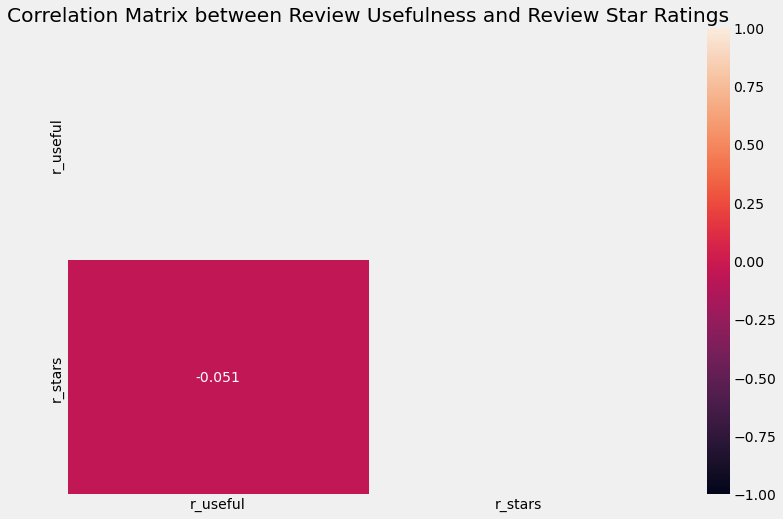

In [38]:
cor = ddf[["r_useful", "r_stars"]].corr().compute()
plt.figure(figsize=(12, 8))
plt.title("Correlation Matrix between Review Usefulness and Review Star Ratings")
sns.heatmap(cor, vmin=-1, vmax=1, annot=True, mask=np.triu(np.ones_like(cor, dtype=bool)))
plt.show()

The correlation map suggest that they don't have significant correlation amongst them.

## Correlation between Usefulness and Popularity

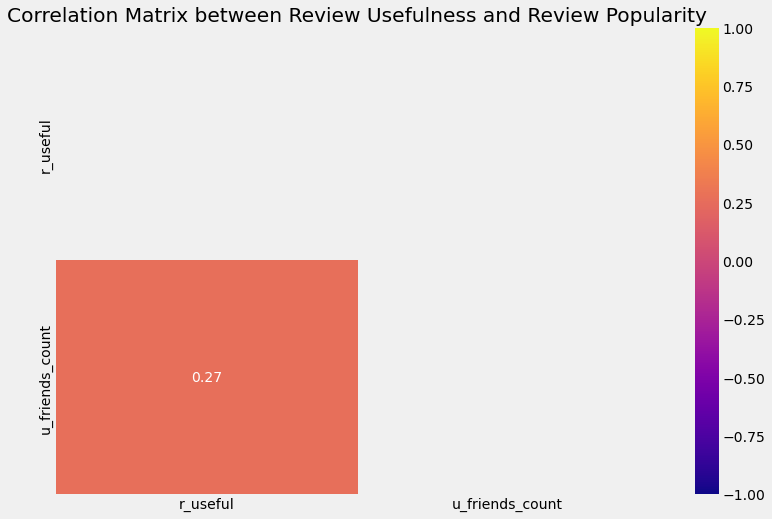

In [39]:
cor = ddf[["r_useful", "u_friends_count"]].corr().compute()
plt.figure(figsize=(12, 8))
plt.title("Correlation Matrix between Review Usefulness and Review Popularity")
sns.heatmap(cor, vmin=-1, vmax=1, annot=True, mask=np.triu(np.ones_like(cor, dtype=bool)), cmap="plasma")
plt.show()

The correlation is not that strong but still it is significant. This indicates that reviewer popularity infact does have an effect on the usefulness of the review.

## Correlation between number of words in a review and review usefulness

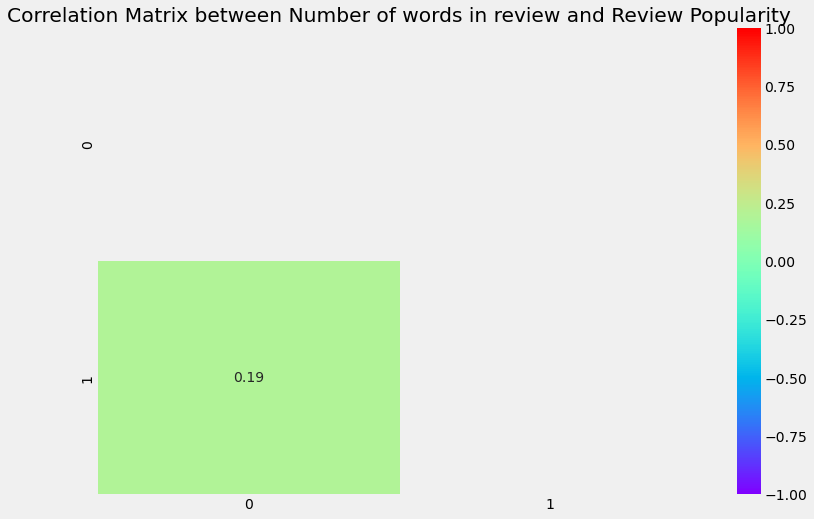

In [40]:
cor = np.corrcoef(n_words, ddf["r_useful"].compute())
plt.figure(figsize=(12, 8))
plt.title("Correlation Matrix between Number of words in review and Review Popularity")
sns.heatmap(cor, vmin=-1, vmax=1, annot=True, mask=np.triu(np.ones_like(cor, dtype=bool)), cmap="rainbow")
plt.show()

## Correlation between Average Word Length of a review and review usefulness

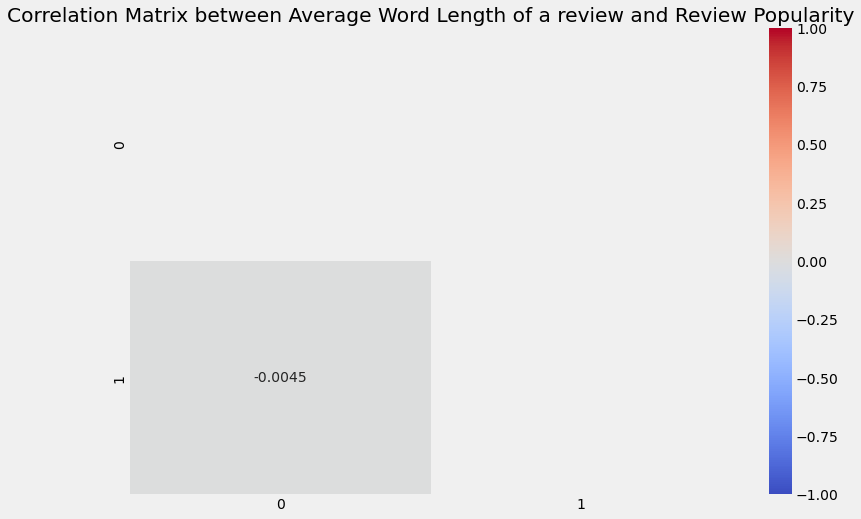

In [41]:
cor = np.corrcoef(avg_word_len, ddf["r_useful"].compute())
plt.figure(figsize=(12, 8))
plt.title("Correlation Matrix between Average Word Length of a review and Review Popularity")
sns.heatmap(cor, vmin=-1, vmax=1, annot=True, mask=np.triu(np.ones_like(cor, dtype=bool)), cmap="coolwarm")
plt.show()

While the number of words in a review affect it's usefulness but the average word length of a review seems to have almost no effect on its usefulness.